# FINM 34700 Quantitative Trading Strartegy

Homework-1 Submitted by Vidhan Ajmera\
Email: vidhanajmera@uchicago.edu

# Futures Spread Dynamics

## Sections
1. Objectives
2. Helper Functions
3. Data Import and cleaning
4. Statistical Analysis
5. Conclusion

# 1. Objective

In this homework, we use 'Nasdaq Data Link' API to source the daily pricing data for 4 different futures contracts, namely:
<b><br>
-  ICE WTI Crude Oil Futures(ICE_T_T_)
-  ICE Gasoil Futures(ICE_G_G_)
-  2y US Treasury Notes(CBT_TU_TU_)
-  30y US Treasury Bonds(CBT_US_US)

Using these contracts, we need to generate a time series for price spreads, which are specified in the assignment as:\
  2. ICE_T_T_ versus ICE_G_G_ x 0.11\
  7. CBT_TU_TU_ versus CBT_US_US x 0.6873

The first spread is also known as 'Gasoil/WTI Crude oil Crack' and I will be refering it as Commodity Spread. The second spread is also known as 2y/30y Treseasury yield spread and I will be refering it as Treasury Spread or Bond spread. All these contracts are traded in US dollars.

The objective is to perform an exploratory data analysis of the two time series and characterize them both individually as well as based on relative dynamics.
    
For this homework, we need to take into account the major events that occured during the given time period. For instance, the impact of spread of the financial contagion that has made headlines up until today, Covid-19 pandemic, Russia's invasion of Ukraine and rising inflation in US economy. 

# 2. Helper Functions

This section includes the import of relevant libraries and defining the functions for fetching, generating, plotting and analyzing the spreads.\
I have leveraged caching for storing the data fetched from Nasdaq Data Link.

In [60]:
import numpy as np
import pandas as pd
import nasdaqdatalink
import scipy.stats as ss
import seaborn as sns
from functools import lru_cache
from statsmodels.tsa.stattools import adfuller
import datetime
import warnings
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [15,10]
warnings.filterwarnings('ignore')


In [2]:
@lru_cache(maxsize=1600)
def fetch_quandl(sec, quarter, year, sde, ede):
    '''
    This function pulls data from the Nasdaqdatalink API for the security provided as input with
    start date and end date
    '''
    raw_data=pd.DataFrame()
    raw_data=nasdaqdatalink.get('OWF/'+ sec + quarter + year + '_IVM', start_date=sde, end_date=ede, returns="pandas")
    raw_data_new=raw_data[raw_data['DtT']>=30]
    raw_data_new2=raw_data_new[['Future']]
    return raw_data_new2
def generate_data(set1,start_date, end_date, quarter,years,factor):
    '''
    For a given pair of futures, this function generates a time series of future prices and spread.  For
    each date in the analysis date range, we filter out all available futures contracts for that date and
    choose the one with lowest time to expiration so long as it is over 30 days.
    ''' 
    df=pd.DataFrame()
    for k in range(len(set1)):
        my_file=pd.DataFrame()
        sde=start_date
        ede=end_date
        qt=quarter
        yt=years
        for j in range(len(yt)):
            for i in range(len(qt)):
                raw_data1=pd.DataFrame()
                raw_data1=fetch_quandl(set1[k],qt[i],yt[j],sde,ede)
                if len(my_file) == 0:
                    my_file=raw_data1
                    sde=my_file.index[-1].strftime('%y-%m-%d')
                    my_file = my_file[:-1]
                elif i==3 and j==1:
                    my_file=pd.concat([my_file,raw_data1],axis=0)
                else:
                    my_file=pd.concat([my_file,raw_data1],axis=0)
                    sde=my_file.index[-1].strftime('%y-%m-%d')
                    my_file = my_file[:-1]
        my_file.rename(columns={"Future": set1[k]},inplace=True)
        if len(df)==0:
            df=my_file
        else:
            df=pd.concat([df,my_file],axis=1)
    df.iloc[:,1]=df.iloc[:,1]*factor
    df['Spread']= round(df.iloc[:,1]-df.iloc[:,0],4)  
    return df
    

In [3]:
def summaryStats(df):
    '''
        The function provides performance statistics for a given return series 
        Inputs: return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output: summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Var (0.5),Skewness and Excess Kurtosis based on monthly returns.
    '''        
    summary = pd.DataFrame(index = df.columns)    
    summary['Annualized Mean'] = df.mean()*252
    summary['Annualized Volatility'] = df.std()*np.sqrt(252)
    summary['Sharpe Ratio'] = summary['Annualized Mean']/summary['Annualized Volatility']    
    summary['Skewness'] = df.skew()
    summary['95% VaR'] = df.quantile(0.05)
    summary['Excess Kurtosis'] = df.kurt()
    
    return summary

# 3. Data Importing and Cleaning

The two spreads will for two dataframes, which are related as follows:\
A)  ICE WTI Crude Oil Futures versus ICE Gasoil Futures Spread--Dataframe: df_cmdty\
B)  2y US Treasury Notes versus 30y US Treasury Bonds--DataFrame: df_bonds

We use generate_data function to fetch the data of all quarterly contracts available at a given date and filter out the price of the contract that is closest to that date and has atleast 30 days to maturity.

In [4]:
setwx=['ICE_T_T_','ICE_G_G_']
setyz=['CBT_TU_TU_', 'CBT_US_US_']
years=['2021', '2022']
quarter='HMUZ'
start_date='2020-12-03'
end_date='2022-08-31'
nasdaqdatalink.ApiConfig.api_key = 'Your API Key'

In [5]:
df_cmdty = generate_data(setwx,start_date, end_date, quarter,years,0.11)
df_cmdty = df_cmdty.rename(columns={'ICE_T_T_': 'ICE_WTI_Crude_Fut','ICE_G_G_': 'ICE_GasOil_Fut'})
df_cmdty.describe()

,ICE_WTI_Crude_Fut,ICE_GasOil_Fut,Spread
count,450.000000,450.000000,450.000000
mean,77.463822,80.412628,2.948806
std,17.571725,25.427611,9.754345
min,45.870000,44.522500,-7.572500
25%,64.862500,60.830000,-3.144375
50%,74.070000,71.018750,-1.603750
75%,90.782500,106.280625,4.641875
max,117.150000,137.500000,31.850000


<b> Observation </b> As seen from the above table, the data is clean and do not contain missing values or NaN values.

In [6]:
df_bonds = generate_data(setyz,start_date, end_date, quarter,years,0.6873)
df_bonds = df_bonds.rename(columns={'CBT_TU_TU_': 'US_2Y_TrsyN_Fut','CBT_US_US_': 'US_30Y_TrsyB_Fut'})
df_bonds.describe()

,US_2Y_TrsyN_Fut,US_30Y_TrsyB_Fut,Spread
count,450.000000,454.000000,450.000000
mean,108.543740,106.877279,-1.721378
std,2.213076,7.065524,5.137271
min,103.837500,90.272559,-13.564900
25%,105.945703,102.724502,-4.085800
50%,109.767188,108.453792,-1.371300
75%,110.351562,111.654033,1.793600
max,110.500000,119.375419,8.903500


<b> Observation </b> As seen from the above table, 4 data points are missing for US 2y Treasury Note time series. This is because the price of the nearest quarterly contract (with more than 30 days to maturity) is not available. Here, we take the assumption that we can use the price of next nearest quarterly contract (with more than 30 days to maturity).

In [7]:
missing_data=df_bonds[df_bonds['US_2Y_TrsyN_Fut'].isna()]
missing_data

,US_2Y_TrsyN_Fut,US_30Y_TrsyB_Fut,Spread
Date,,,
2021-02-05,NaN,114.585797,NaN
2021-02-09,NaN,114.865013,NaN
2021-02-15,NaN,114.199191,NaN
2021-05-07,NaN,108.571922,NaN


<b> Observation </b> In the above tabel, first three dates belong to same Futures contract( 2Y Treasury Note March-2021 or CB_TU_TU_H2021_IVM ) and the last data belong to the next quarterly contract( 2Y Treasury Note June-2021 or CB_TU_TU_M2021_IVM ). We can fix this by fetching price-data for next available contract.

In [8]:
df_Jun21=fetch_quandl('CBT_TU_TU_', 'M', '2021', '2021-02-05', '2021-02-15')
df_Sep21=fetch_quandl('CBT_TU_TU_', 'U', '2021', '2021-02-05', '2021-02-15')

In [9]:
for i in range(3):
    y=missing_data.index[i].strftime('%Y-%m-%d')
    df_bonds.at[y,'US_2Y_TrsyN_Fut']=df_Jun21['Future'].iloc[i]
    df_bonds.at[y,'Spread']=df_bonds.at[y,'US_30Y_TrsyB_Fut']-df_bonds.at[y,'US_2Y_TrsyN_Fut']
zz=missing_data.index[3].strftime('%Y-%m-%d')
df_bonds.at[zz,'US_2Y_TrsyN_Fut']=df_Sep21['Future'].iloc[3]
df_bonds.at[zz,'Spread']=df_bonds.at[zz,'US_30Y_TrsyB_Fut']-df_bonds.at[zz,'US_2Y_TrsyN_Fut']

In [10]:
df_bonds.describe()

,US_2Y_TrsyN_Fut,US_30Y_TrsyB_Fut,Spread
count,454.000000,454.000000,454.000000
mean,108.560686,106.877279,-1.683407
std,2.210619,7.065524,5.136220
min,103.837500,90.272559,-13.564900
25%,106.002734,102.724502,-3.999400
50%,109.814063,108.453792,-1.360550
75%,110.353125,111.654033,1.802975
max,110.500000,119.375419,8.903500


# 4. Data Analysis

<B> 4.1 Individual Spread Analysis: Commodity Spread <B> 

We start with Commodity spread and analyse the time series using various plots and statistical metrices.

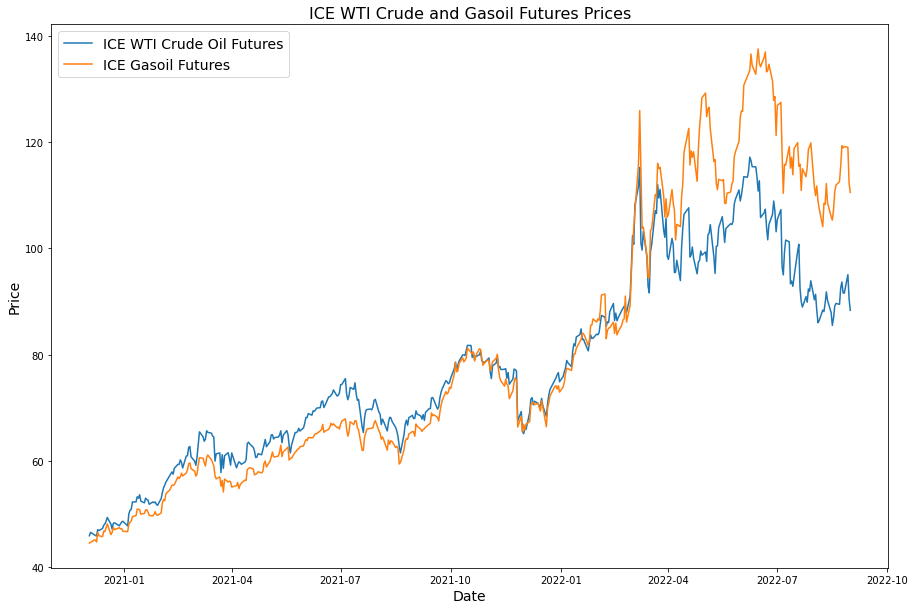

In [30]:
plt.plot(df_cmdty.ICE_WTI_Crude_Fut, label = "ICE WTI Crude Oil Futures")
plt.plot(df_cmdty.ICE_GasOil_Fut, label = "ICE Gasoil Futures" )
plt.legend(fontsize = 14)
plt.xlabel('Date',fontsize = 14)
plt.ylabel('Price',fontsize = 14)
plt.title("ICE WTI Crude and Gasoil Futures Prices",fontsize = 16)
plt.show()
None

<b> Observation </b> The two futures price series move synchronously for the two years, except for the last six month period, which can be seen as an impact of crude supply disruptions emerging from ban on Russian Crude Oil.

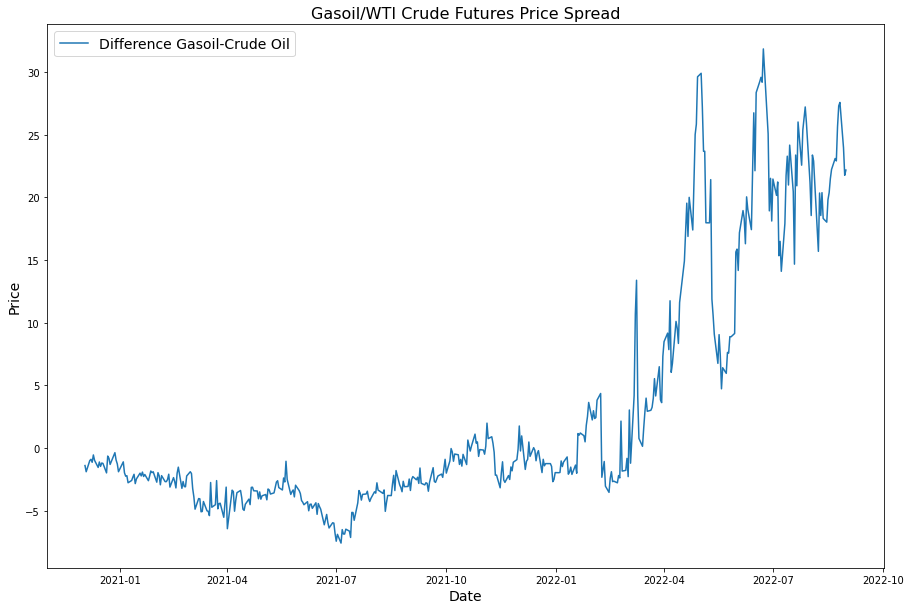

In [32]:
plt.plot(df_cmdty.Spread, label = "Difference Gasoil-Crude Oil")
plt.legend(fontsize = 14)
plt.xlabel('Date',fontsize = 14)
plt.ylabel('Price',fontsize = 14)
plt.title("Gasoil/WTI Crude Futures Price Spread",fontsize = 16)
plt.show()
None

<b> Observation </b> The spread is negative during the year 2021 because of lacklusture demand of Gasoil fuel in response to lockdowns imposed due Omicron outbreak. But this trend reversed at the start of 2022, when demand for Gasoil and heating oil pushed refiners to run refineries at full thru'put. Volatility in spread is due to market supply demand imbalances and OPEC+ production quota changes.

Next, I have prepared a daily return series on Futures contracts to get a better understanding of volatility and mean returns.

In [35]:
df_cmdty_returns=df_cmdty.pct_change()
cmdty_pfm_stats=summaryStats(df_cmdty_returns)
cmdty_pfm_stats.head(2)

,Annualized Mean,Annualized Volatility,Sharpe Ratio,Skewness,95% VaR,Excess Kurtosis
ICE_WTI_Crude_Fut,0.449313,0.401994,1.11771,-0.924610,-0.037498,3.756600
ICE_GasOil_Fut,0.588074,0.392164,1.49956,-0.572301,-0.040713,3.101973


<b> Observation </b> As seen from the performance statistics of the returns of the two futures contracts, Sharpe ratio of GasOil Futures(1.5) is higher that WTI Futures(1.1), becasue of the higher returns with almost similar volatility. Both the serieses have similar volatilities. Skewness is worse in case of Crude Oil as compare Gasoil.

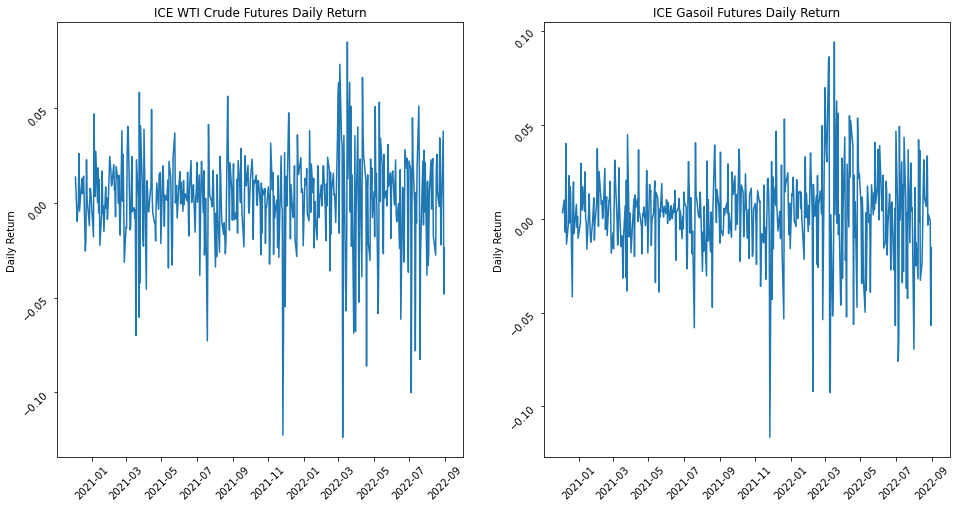

In [41]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.plot(df_cmdty_returns.ICE_WTI_Crude_Fut, label = "ICE WTI Crude Oil Futures")
ax1.set(title = "ICE WTI Crude Futures Daily Return")
ax1.tick_params(labelrotation = 45)
ax1.set_ylabel("Daily Return")
ax2.plot(df_cmdty_returns.ICE_GasOil_Fut, label = "ICE Gasoil Futures" )
#plt.plot(df_cmdty_returns.Spread, label = "Difference Gasoil-Crude Oil")
ax2.set(title = "ICE Gasoil Futures Daily Return")
ax2.tick_params(labelrotation = 45)
ax2.set_ylabel("Daily Return")
plt.show()
None

<b>Observation:</b> From the plot, we observe the two series have very similar looking daily return distribution over the last two years.

Next I compute and analyse the difference(d) between daily price spread and the Bi-weekly/Monthly/Quarterly SMAs of the same spread.

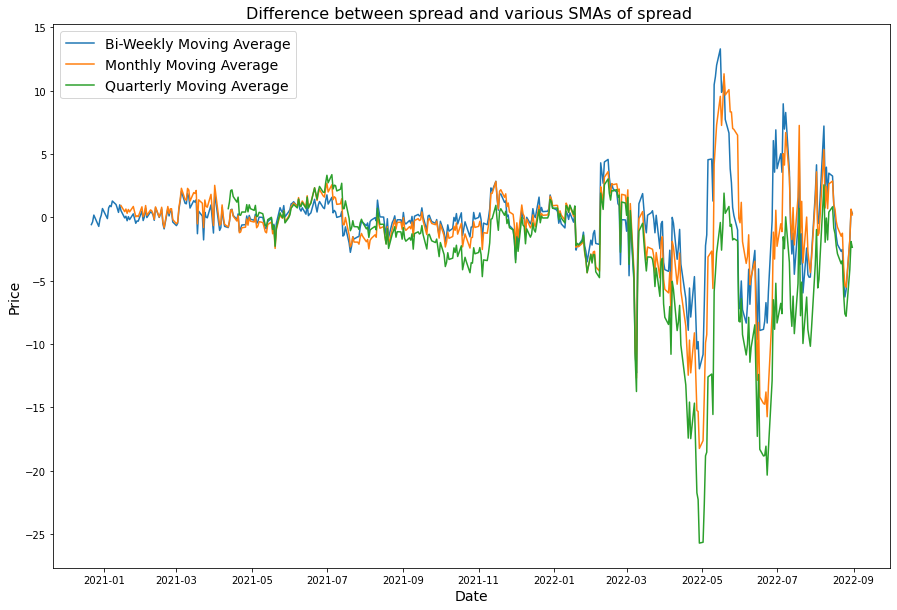

In [42]:
df_cmdty_roll14=df_cmdty.rolling(window=14).mean().dropna()
df_cmdty_roll30=df_cmdty.rolling(window=30).mean().dropna()
df_cmdty_roll90=df_cmdty.rolling(window=90).mean().dropna()
#df_cmdty_roll180=df_cmdty.rolling(window=180).mean().dropna()
plt.plot(df_cmdty_roll14.Spread-df_cmdty.Spread, label = "Bi-Weekly Moving Average")
plt.plot(df_cmdty_roll30.Spread-df_cmdty.Spread, label = "Monthly Moving Average" )
plt.plot(df_cmdty_roll90.Spread-df_cmdty.Spread, label = "Quarterly Moving Average" )
plt.legend(fontsize = 14)
plt.xlabel('Date',fontsize = 14)
plt.ylabel('Price',fontsize = 14)
plt.title("Difference between spread and various SMAs of spread ",fontsize = 16)
plt.show()

<b> Observation </b> As seen from the graph, the simple moving averages seem to move synchronously for most of the period, except during the last six months, where I presume is the impact of supply-demand disruptions due to sanctions on Russian crude export. An important observation from the graph is that during last six months, bi-weekly average always supercedes the quarterly moving average.

<B> 4.2 Individual Spread Analysis: Commodity Spread <B> 

Next, we move to Treasury spread, and analyse the time series using various plots and statistical metrices.

In [45]:
df_bonds.describe()

,US_2Y_TrsyN_Fut,US_30Y_TrsyB_Fut,Spread
count,454.000000,454.000000,454.000000
mean,108.560686,106.877279,-1.683407
std,2.210619,7.065524,5.136220
min,103.837500,90.272559,-13.564900
25%,106.002734,102.724502,-3.999400
50%,109.814063,108.453792,-1.360550
75%,110.353125,111.654033,1.802975
max,110.500000,119.375419,8.903500


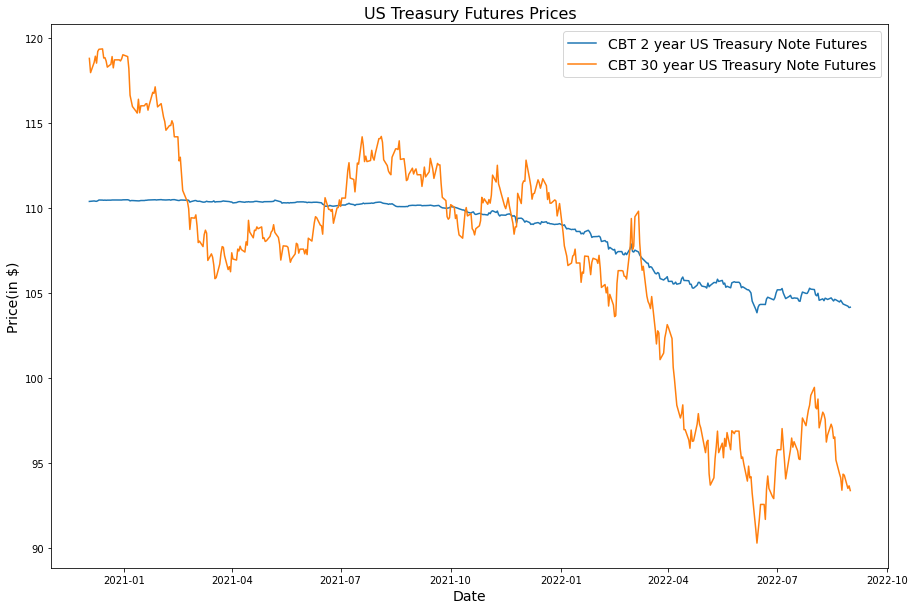

In [46]:
plt.plot(df_bonds.US_2Y_TrsyN_Fut, label = "CBT 2 year US Treasury Note Futures")
plt.plot(df_bonds.US_30Y_TrsyB_Fut, label = "CBT 30 year US Treasury Note Futures")
#plt.plot(df_bonds.Spread, label = "Difference 30Y US Treasury-2Y US Treasury" )
plt.legend(fontsize = 14)
plt.xlabel('Date',fontsize = 14)
plt.ylabel('Price(in $)',fontsize = 14)
plt.title("US Treasury Futures Prices",fontsize = 16)
plt.show()

<b> Observation </b> As seen from the graph, the price of a 30Y US treasury bond fluctuated between a range of 90 to 120, where as 2Y US treasury has a tight range from 105 to 110. In last six months, a sharp drop in the price of 30 year bond is due to multiple rate hikes in interest rates by the Fed during the period. 2year Treasury prices have also declined, but not as significantly.

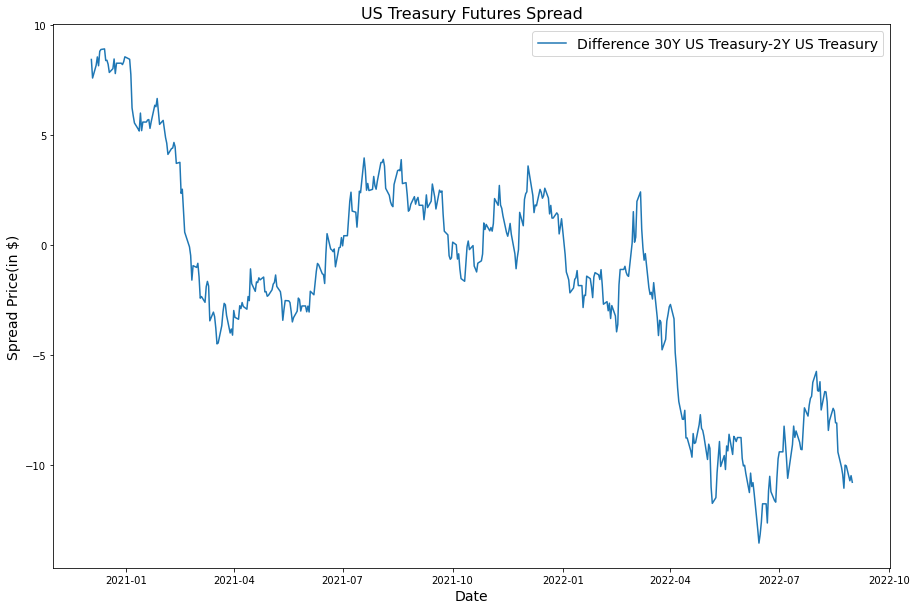

In [47]:
plt.plot(df_bonds.Spread, label = "Difference 30Y US Treasury-2Y US Treasury" )
plt.legend(fontsize = 14)
plt.xlabel('Date',fontsize = 14)
plt.ylabel('Spread Price(in $)',fontsize = 14)
plt.title("US Treasury Futures Spread",fontsize = 16)
plt.show()

 <b> Observation </b> As seen from the graph, for the past 6 months, the spread has turned negative which indicates inversion of yield curve. This is referred to as recessionary environment.

In [48]:
df_bonds_returns=df_bonds.pct_change()
bonds_pfm_stats=summaryStats(df_bonds_returns)
bonds_pfm_stats.head(2)

,Annualized Mean,Annualized Volatility,Sharpe Ratio,Skewness,95% VaR,Excess Kurtosis
US_2Y_TrsyN_Fut,-0.032194,0.015318,-2.101705,-0.675321,-0.001922,5.116886
US_30Y_TrsyB_Fut,-0.128655,0.104113,-1.235721,-0.019180,-0.010651,0.550452


<b> Observation </b> As seen from the performance statistics of the returns of the two futures contracts, Sharpe ratios on both the Futures returns are negative. This is because of the negative mean return over the given period. Also, the volatility in 30Y Treasury bonds is substantially high compared to 2Y Treasury Note.

Next, I have plotted the daily returns on these futures for better understanding of return and volatility.

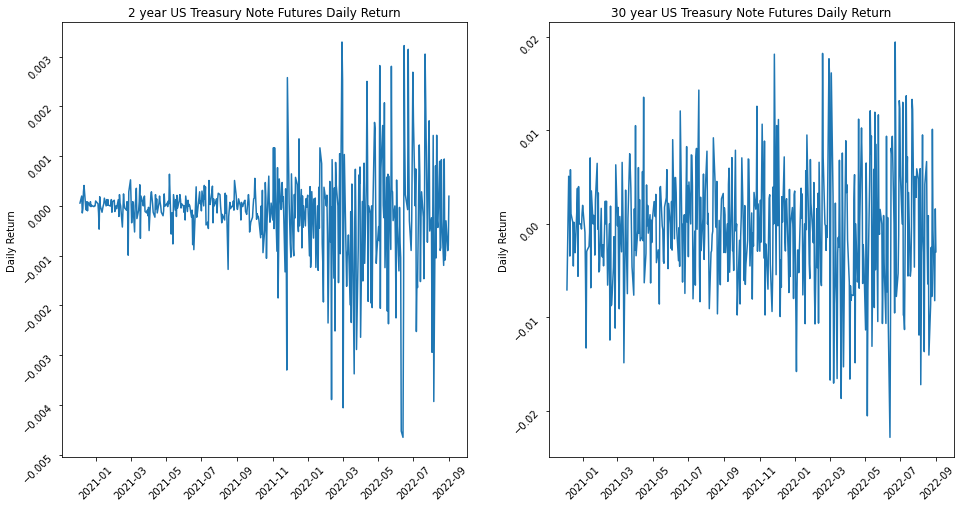

In [50]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.plot(df_bonds_returns.US_2Y_TrsyN_Fut, label = "2 year US Treasury Note Futures")
ax1.set(title = "2 year US Treasury Note Futures Daily Return")
ax1.tick_params(labelrotation = 45)
ax1.set_ylabel("Daily Return")
ax2.plot(df_bonds_returns.US_30Y_TrsyB_Fut, label = "30 year US Treasury Note Futures")
ax2.set(title = "30 year US Treasury Note Futures Daily Return")
ax2.tick_params(labelrotation = 45)
ax2.set_ylabel("Daily Return")
plt.show()
None

<b> Observation </b> Clearly, 30y Treasury returns have more noise compared to 2y Treasury returns.  Both these serieses look stationary and AD fuller test can be used to test the stationarity of these serieses

Next I compute and analyse the difference(d) between daily price spread and the Bi-weekly/Monthly/Quarterly SMAs of the same spread.

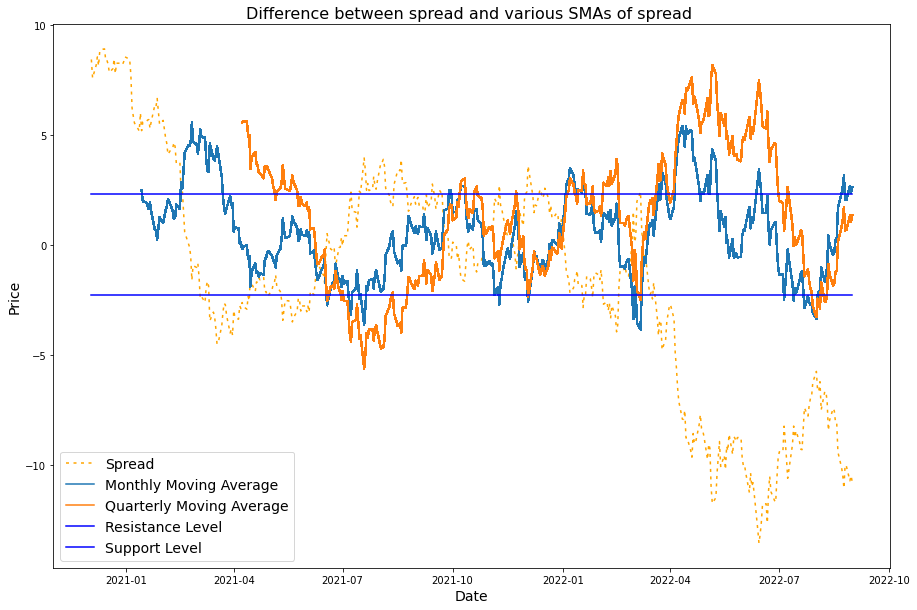

In [51]:
df_bonds_roll14=df_bonds.rolling(window=14).mean().dropna()
df_bonds_roll30=df_bonds.rolling(window=30).mean().dropna()
df_bonds_roll90=df_bonds.rolling(window=90).mean().dropna()
dummy_1=pd.DataFrame(index= df_bonds.index)
dummy_1['Spread']=2.3
dummy_2=pd.DataFrame(index= df_bonds.index)
dummy_2['Spread']=-2.3
df_cmdty_roll180=df_cmdty.rolling(window=180).mean().dropna()
plt.plot(df_bonds.Spread, label = "Spread",color='orange',linestyle=(0, (2, 3)))
plt.plot(df_bonds_roll30.Spread-df_bonds.Spread, label = "Monthly Moving Average" ,antialiased=False )
plt.plot(df_bonds_roll90.Spread-df_bonds.Spread, label = "Quarterly Moving Average",antialiased=False)
plt.plot(dummy_1.Spread, label = "Resistance Level", color='blue' )
plt.plot(dummy_2.Spread, label = "Support Level", color='blue' )
plt.legend(fontsize = 14)
plt.xlabel('Date',fontsize = 14)
plt.ylabel('Price',fontsize = 14)
plt.title("Difference between spread and various SMAs of spread ",fontsize = 16)
plt.show()

<b> Observation </b>Above plot suggests that, more often than not, the spread price moves away from its moving average. This creates a trading opportunity where we can identify supports and resistances and buy(short) the spread if it crosses the support(resistance) level. Dotted line represents the mean value of the spread

<B> 4.3 Relative Spread Analysis: Commodity Spread <B> 

Now, we analyse the two spreads and difference between them.

In [52]:
df_spread=df_cmdty.copy()
df_spread=df_spread.rename(columns={'Spread': 'Spread_Cmdty'})
df_spread=df_spread.drop(['ICE_WTI_Crude_Fut','ICE_GasOil_Fut'],axis=1)
df_spread['Spread_Bonds']=df_bonds['Spread']
df_spread['Delta']=df_spread['Spread_Bonds']-df_spread['Spread_Cmdty']

In [53]:
df_spread.describe()

,Spread_Cmdty,Spread_Bonds,Delta
count,450.000000,450.000000,450.000000
mean,2.948806,-1.692546,-4.641352
std,9.754345,5.124351,14.057946
min,-7.572500,-13.564900,-42.378600
25%,-3.144375,-3.999400,-9.032700
50%,-1.603750,-1.360550,1.327350
75%,4.641875,1.802975,4.469200
max,31.850000,8.903500,10.441000


The spread data consists of 450 rows since bonds markets remain closed on 4 dates.

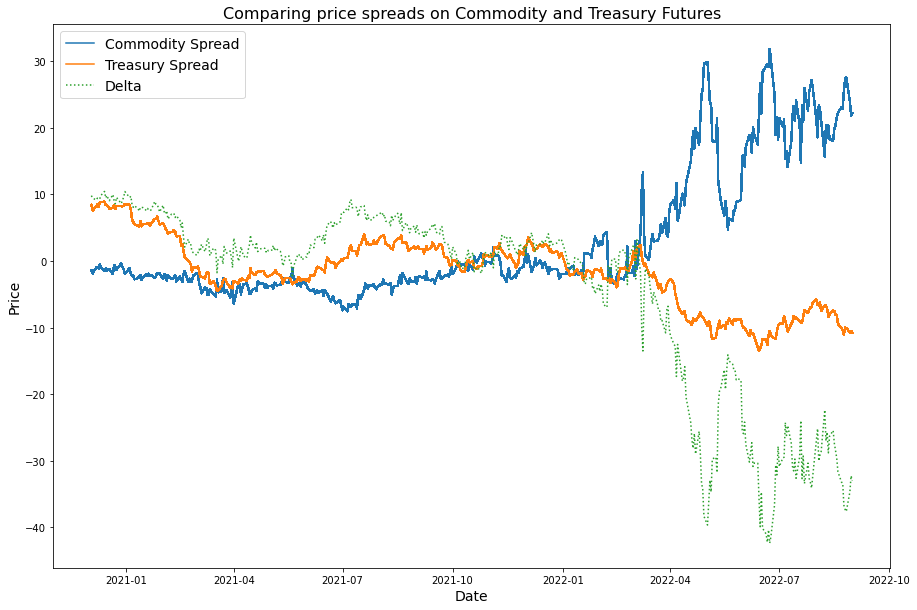

In [54]:
plt.plot(df_spread.Spread_Cmdty, label = "Commodity Spread",antialiased=False)
plt.plot(df_spread.Spread_Bonds, label = "Treasury Spread",antialiased=False )
plt.plot(df_spread.Delta, label = "Delta",linestyle='dotted')
plt.legend(fontsize = 14)
plt.xlabel('Date',fontsize = 14)
plt.ylabel('Price',fontsize = 14)
plt.title("Comparing price spreads on Commodity and Treasury Futures",fontsize = 16)
plt.show()
None

<b> Observation </b> Important point to note from the above plot is that both the spreads moved in opposite directions after having a narrow range of movements. Due to the impact of Covid-19, the Commodity spread grew substantially because of drop in crude oil prices. Treasury spread remain in bear sentiments, probably becasue of the financial aid and loan moratoriums offered by the US government, as was the case with governments accross the globe.

Next I performed stationarity tests on both the spreads to determine the characterstics of time serieses.

In [90]:
t_stat, p_value, _, _, critical_values, _  = adfuller(df_spread['Spread_Bonds'].values, autolag='AIC')
for key, value in critical_values.items():
    if key=="10%":
        print(f'ADF Statistic for Bond Spread is: {t_stat:.2f} against Critical value {key}, {value:.2f}')
t_stat, p_value, _, _, critical_values, _  = adfuller(df_spread['Spread_Cmdty'].values, autolag='AIC')
for key, value in critical_values.items():
    if key=="10%":
        print(f'ADF Statistic for Commodity Spread is: {t_stat:.2f} against Critical value {key}, {value:.2f}')

ADF Statistic for Bond Spread is: -1.45 against Critical value 10%, -2.57
ADF Statistic for Commodity Spread is: -1.16 against Critical value 10%, -2.57


<b> Observation </b> As we see that the ADF test statistics for both the serieses are much higher than critical values at 10% significance, we can not reject the null hypothesis. Both the price spread time series are non-stationaty. 

Next I want to understand the degree of correlation among all the time serieses that I have explored as yet.

In [95]:
df_spread['Crude Oil']=df_cmdty['ICE_WTI_Crude_Fut']
df_spread['Gasoil']=df_cmdty['ICE_GasOil_Fut']
df_spread['2Y Treasury']=df_bonds['US_2Y_TrsyN_Fut']
df_spread['30Y Treasury']=df_bonds['US_30Y_TrsyB_Fut']

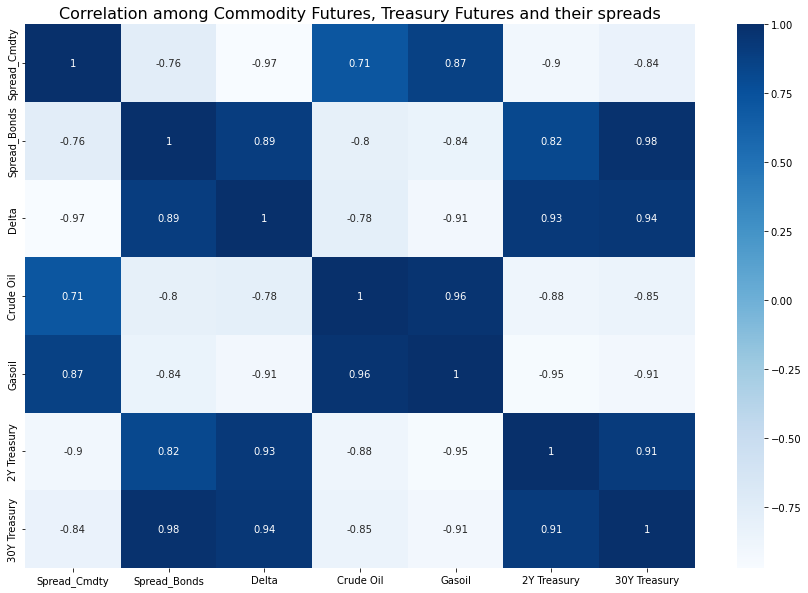

In [96]:
sns.heatmap(df_spread.corr(),annot=True,cmap='Blues')
plt.title("Correlation among Commodity Futures, Treasury Futures and their spreads", fontsize = 16)
plt.show()

In [97]:
asset_corr=df_spread.corr()
sorted_corr = asset_corr.unstack().sort_values().to_frame('Correlations')
sorted_corr = sorted_corr[sorted_corr['Correlations'] != 1]

In [98]:
sorted_corr.nlargest(3,'Correlations')

,,Correlations
Spread_Bonds,30Y Treasury,0.983961
30Y Treasury,Spread_Bonds,0.983961
Crude Oil,Gasoil,0.962588


<b> Observation </b> The heat-map shown above helps in visualization of correlation between various data serieses. From table shown above, we can see that correlation between 30Y Treasury Bonds and corresponding bond spread is highest. Crude oil and Gasoil Futures prices are also highly correlated.

In [99]:
sorted_corr.nsmallest(3,'Correlations')

,,Correlations
Spread_Cmdty,Delta,-0.971785
Delta,Spread_Cmdty,-0.971785
2Y Treasury,Gasoil,-0.954403


<b> Observation </b> From table shown above, we observe that delta between spreads has near -1 corretation with Commodity spread, which is as per its definition (Delta=Bond Spread-Commodity spread). We can also look at the correlation between Futures price of 2Y treasury note and Gasoil, which suggests that these can act as a good hedging instrument for each other.

# Conclusion

Following is a breif summary of observations and conclusions from the above exploratory data analysis:


1. Both spreads have suffered severe shocks due to Covid-19 pandemic. The volatility in price spreads have increased many-fold compared to the prevailing average level.
2. Commodity spread or 'Gasoil/WTI crude Futures crack' has been impacted by EU's Oil Embargo on Russia. Treasury spread has been impacted by rate hikes by the Fed. Both the spreads are non-stationary.
3. Correlation is very high for Crude Oil and Gasoil Futures pair, while negative for Gasoil and 2Y Treasury pair. For a highly correlated and mean reverting pairs, we can use a rolling windows to generate trading strategies.
4. The analysis of difference between Treasury Spread and Simple moving averages of the spread indicates a trading signal in a range from -2.3 to +2.3. The spread can be traded based on the signal moving in and out of this range.